# Attention RNN

Hier ist mein Verusch das Paper in Code umzusetzen. Ich bin mir bei der Berechnung des Context Vektors sehr unsicher, wollte es aber dennoch abgeben. Gibt es vielleicht irgendwo eine Musterlösung für die Implementierung? Auch wenn diese wahrscheinlich im Kontext von NLP / Übersetzung ist fände ich sie sehr spannend anzusehen!

In [ ]:
import torch.nn as nn
import torch
import numpy as np

In [2]:
import torch
import torch.nn as nn
torch.manual_seed(42)

def init_weights(module: nn.Module):
    """Initializes a single module depending on its type"""
    for param in module.parameters():
        torch.nn.init.xavier_uniform_(param.data)

# PS: die Klasse heißt 'Second' weil ich zuerst eine Lösung hatte, dort aber nicht mehr weitergekommen bin. 
# Ich habe dann mit dem Second begonnen & trainiert und wenn ich es jetzt im nachhinein umbenenne kann ich die gespeicherten Models nicht mehr laden.
# Vielleicht gibt es da eine Lösung - aber ich dachte mir der Name der Klasse ist ja eh nicht wichtig
class SecondAttentionRNN(nn.Module):
    def __init__(self, input_len=1, n=5, n_hat=3, output_len=1) -> None:
        super(SecondAttentionRNN, self).__init__()
        self.n = n # hidden size
        self.n_hat = n_hat # alignment model hidden size
        
        # encoder
        self.encoder_h_Ux = nn.Parameter(torch.FloatTensor(n, input_len))
        self.encoder_h_Uh = nn.Parameter(torch.FloatTensor(n, n))
        self.encoder_h_ub = nn.Parameter(torch.FloatTensor(n, 1))
        self.encoder_g_Ux = nn.Parameter(torch.FloatTensor(n, input_len))
        self.encoder_g_Uh = nn.Parameter(torch.FloatTensor(n, n))
        self.encoder_g_ub = nn.Parameter(torch.FloatTensor(n, 1))

        self.encoder_h_Rx = nn.Parameter(torch.FloatTensor(n, input_len))
        self.encoder_h_Rh = nn.Parameter(torch.FloatTensor(n, n))
        self.encoder_h_rb = nn.Parameter(torch.FloatTensor(n, 1))
        self.encoder_g_Rx = nn.Parameter(torch.FloatTensor(n, input_len))
        self.encoder_g_Rh = nn.Parameter(torch.FloatTensor(n, n))
        self.encoder_g_rb = nn.Parameter(torch.FloatTensor(n, 1))

        self.encoder_h_Wh = nn.Parameter(torch.FloatTensor(n, n))
        self.encoder_h_Wx = nn.Parameter(torch.FloatTensor(n, input_len))
        self.encoder_h_bias = nn.Parameter(torch.FloatTensor(n, 1))
        self.encoder_g_Wh = nn.Parameter(torch.FloatTensor(n, n))
        self.encoder_g_Wx = nn.Parameter(torch.FloatTensor(n, input_len))
        self.encoder_g_bias = nn.Parameter(torch.FloatTensor(n, 1))

        # decoder
        self.s_Ws = nn.Parameter(torch.FloatTensor(n, n))
        self.s_hat_Wx = nn.Parameter(torch.FloatTensor(n, input_len))
        self.z_Wx = nn.Parameter(torch.FloatTensor(n, input_len))
        self.r_Wx = nn.Parameter(torch.FloatTensor(n, input_len))

        self.s_Us = nn.Parameter(torch.FloatTensor(n, n))
        self.z_Us = nn.Parameter(torch.FloatTensor(n, n))
        self.r_Us = nn.Parameter(torch.FloatTensor(n, n))

        self.s_C = nn.Parameter(torch.FloatTensor(n, n * 2) )
        self.z_C = nn.Parameter(torch.FloatTensor(n, n * 2))
        self.r_C = nn.Parameter(torch.FloatTensor(n, n * 2))
        self.decoder_s_hat_bias = nn.Parameter(torch.FloatTensor(n, 1))

        self.Wa = nn.Parameter(torch.FloatTensor(n_hat, n))
        self.Ua = nn.Parameter(torch.FloatTensor(n_hat, 2 * n))
        self.Va = nn.Parameter(torch.FloatTensor(n_hat, 1))

        # output
        self.oWx  = nn.Parameter(torch.FloatTensor(output_len, input_len))
        self.oWs = nn.Parameter(torch.FloatTensor(output_len, n))
        self.ob = nn.Parameter(torch.FloatTensor(output_len, 1))
        
        init_weights(self)

    # device is just here so I can use it with my existing training pipeline
    def forward(self, input_sequence, horizon=20, device=torch.device("cpu")):
        input_sequence = [torch.tensor([[input]], dtype=torch.float32) for input in input_sequence] # map input values to tensors

        # Encoder
        forward_hidden_states = torch.tensor([])
        backward_hidden_states = torch.tensor([])

        encoder_h = torch.zeros((self.n, 1))
        encoder_g = torch.zeros((self.n, 1))
        for x_t in input_sequence: # compute forward hidden layers
            encoder_h_update_gate = torch.sigmoid(torch.mm(self.encoder_h_Ux, x_t) + torch.mm(self.encoder_h_Uh, encoder_h) + self.encoder_h_ub)
            encoder_h_reset_gate = torch.sigmoid(torch.mm(self.encoder_h_Rx, x_t) + torch.mm(self.encoder_h_Rh, encoder_h) + self.encoder_h_rb)
            encoder_h_hat = torch.tanh(torch.mm(self.encoder_h_Wx, x_t) + (encoder_h_reset_gate * torch.mm(self.encoder_h_Wh, encoder_h)) + self.encoder_h_bias)
            encoder_h = (1 - encoder_h_update_gate) * encoder_h + encoder_h_update_gate * encoder_h_hat
            
            forward_hidden_states = torch.hstack([forward_hidden_states, encoder_h])

        for x_t in reversed(input_sequence): # compute backward hidden layers
            encoder_g_update_gate = torch.sigmoid(torch.mm(self.encoder_g_Ux, x_t) + torch.mm(self.encoder_g_Uh, encoder_g) + self.encoder_g_ub)
            encoder_g_reset_gate = torch.sigmoid(torch.mm(self.encoder_g_Rx, x_t) + torch.mm(self.encoder_g_Rh, encoder_h) + self.encoder_g_rb)
            encoder_g_hat = torch.tanh(torch.mm(self.encoder_g_Wx, x_t) + (encoder_g_reset_gate * torch.mm(self.encoder_g_Wh, encoder_g)) + self.encoder_g_bias)
            encoder_g = (1 - encoder_g_update_gate) * encoder_g + encoder_g_update_gate * encoder_g_hat
            backward_hidden_states = torch.hstack([backward_hidden_states, encoder_g])

        h_i = torch.vstack([forward_hidden_states, backward_hidden_states])

        # Decoder
        s = torch.tanh(torch.mm(self.s_Ws, backward_hidden_states[:,-1].view(self.n, 1))) # initial s
        outputs = torch.tensor([])

        for prediction_step in range(horizon):
            if prediction_step == 0:
                x_t = input_sequence[-1] # use last input
            else:
                x_t = outputs[0][-1].unsqueeze(dim=0).unsqueeze(dim=1) # use last prediction
            # c_i is a weighted sum --> resulting in a vector of dimension (2n, 1)
            alphas = torch.tensor([])
            for j in range(len(input_sequence)): # paper page 13 -> weighted sum over columns
                h_ij = torch.reshape(h_i[:,j], (self.n * 2, 1))
                transposed_V_a = torch.transpose(self.Va, 0, 1)
                e_ij = torch.mm(transposed_V_a, torch.tanh(torch.mm(self.Wa, s) + torch.mm(self.Ua, h_ij)))

                e_ik_sum = torch.exp(h_i).sum(dim=1).view(self.n*2,1) # row wise sum of exp(h_i)
                alpha_ij = torch.exp(e_ij) / e_ik_sum
                alphas = torch.hstack([alphas, alpha_ij])

            
            c_i = torch.zeros(self.n * 2,1) # dimensions: (2n, 1??)
            for j in range(len(input_sequence)):
            #     # c_i = torch.vstack([c_i, torch.dot(alphas[:,j], h_i[:,j])]) -> results in (input_len x 1) matrix - so can't be right 
                c_i += (alphas[:,j] * h_i[:,j]).view(self.n * 2,1) # really not sure about this
            
            # c_i is now of shape (10,1), but is it calculated correctly?
            decoder_r_gate = torch.sigmoid(torch.mm(self.r_Wx, x_t) + torch.mm(self.r_Us, s) + torch.mm(self.r_C, c_i)) # gate
            decoder_z_gate = torch.sigmoid(torch.mm(self.z_Wx, x_t) + torch.mm(self.z_Us, s) + torch.mm(self.z_C, c_i)) # gate
            s_hat = torch.tanh(torch.mm(self.r_Wx, x_t) + torch.mm(self.s_Us, (decoder_r_gate * s)) + torch.mm(self.r_C, c_i) + self.decoder_s_hat_bias)
            s = (1-decoder_z_gate) * s + decoder_z_gate * s_hat

            output = torch.mm(self.oWx, x_t) + torch.mm(self.oWs, s) + self.ob
            outputs = torch.hstack([outputs, output])
        return outputs.squeeze()

TrainingStats(train_loss=[111.31882, 0.44407466, 0.36427766, 0.33888665, 0.30611593, 0.28080943, 0.2617212, 0.24497126, 0.23531927, 0.22881389, 0.22121018, 0.21962477, 0.20795706, 0.20506494, 0.20509736, 0.19311778, 0.18599823, 0.4676406, 0.26636282, 0.25011843, 0.23654841, 0.22194366, 0.20597649, 0.1907658, 0.18009461, 0.16743106, 0.15228273, 0.14301187, 0.13463001, 0.12777202, 0.12085529, 0.118698776, 0.11208702, 0.10824632, 0.102225035, 0.09686, 0.0926389, 0.08891793, 0.08114174, 0.07708204, 0.07477191, 0.06904977, 0.065346375, 0.062304053, 0.05755555, 0.055958193, 0.05131994, 0.048446544, 0.045238506, 0.04455269], val_loss=[0.4870697, 0.42781958, 0.3816238, 0.34737182, 0.31028223, 0.28209072, 0.26396245, 0.25245637, 0.2441001, 0.24100403, 0.22738513, 0.22222976, 0.22093554, 0.21951985, 0.21541886, 0.21075201, 0.20925355, 0.27991596, 0.25898105, 0.24520545, 0.23201041, 0.2189488, 0.20537171, 0.19301811, 0.18212628, 0.16647409, 0.1528492, 0.13871595, 0.12753375, 0.11828794, 0.1136497

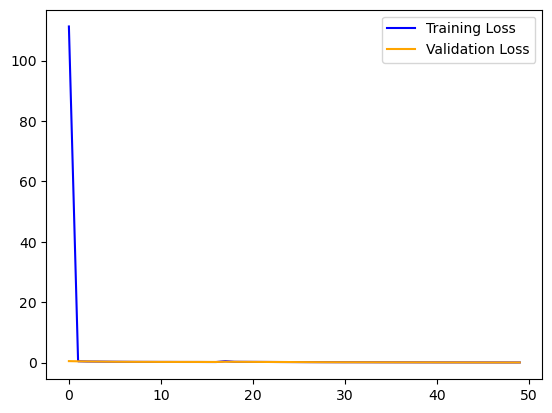

In [157]:
import torch
import torch.nn as nn
from pipeline import train, evaluate
from sklearn.model_selection import train_test_split
from data_generation import generate_longterm_data

NUM_SEQ = 1000
HORIZON=20
data_set, labels = generate_longterm_data(NUM_SEQ, variable_steps=False, noise=True, horizon=HORIZON)

X_train, X_test, y_train, y_test = train_test_split(data_set, labels, test_size=0.2, random_state=42)

attention_model = SecondAttentionRNN(1,30, 30, 1)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
adam = torch.optim.Adam(attention_model.parameters(), lr=3e-4)
EPOCHS = 50


adam = torch.optim.Adam(attention_model.parameters(), lr=3e-4)

train(attention_model, EPOCHS, X_train, y_train, loss_f=mae_loss, optimizer=adam)

(0.04561947, 0.03340146)

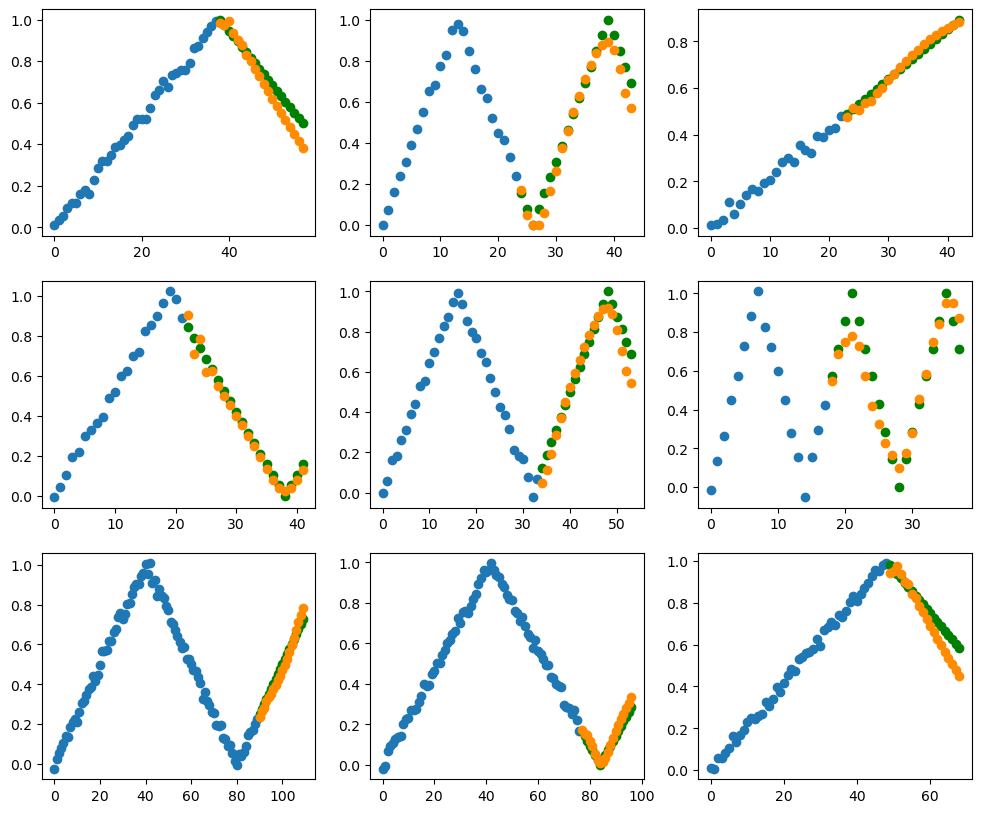

In [158]:
evaluate(attention_model, X_test, y_test, visualize_start_idx=18, loss_fn=nn.L1Loss())

In [159]:
# torch.save(attention_model, "attention-50.pt")

TrainingStats(train_loss=[0.040686265, 0.0422894, 0.040147126, 0.037746802, 0.037071653, 0.036791664, 0.03528919, 0.033814773, 0.033346724, 0.03351991, 0.033378076, 0.031958867, 0.032564253, 0.031556666, 0.030528652, 0.029836252, 0.030019792, 0.02858446, 0.02709255, 0.028820302, 0.028070552, 0.027990505, 0.028100993, 0.027267404, 0.026370436, 0.0271946, 0.027350992, 0.02620603, 0.02706347, 0.026307339, 0.025703806, 0.025013838, 0.025146523, 0.02378012, 0.024377793, 0.023738239, 0.02408549, 0.023636898, 0.023448806, 0.022549817, 0.022598127, 0.023204453, 0.02229618, 0.02363781, 0.023124112, 0.021625603, 0.021744855, 0.02179393, 0.020870514, 0.02186552], val_loss=[0.061785102, 0.040651526, 0.037114136, 0.045195222, 0.031850107, 0.034185514, 0.03964161, 0.026444148, 0.03739869, 0.04198273, 0.03181703, 0.03365689, 0.032840036, 0.032343905, 0.030382913, 0.04023523, 0.026562134, 0.026416168, 0.033263873, 0.027823502, 0.025441403, 0.023481932, 0.03195941, 0.032349538, 0.025913585, 0.032033626

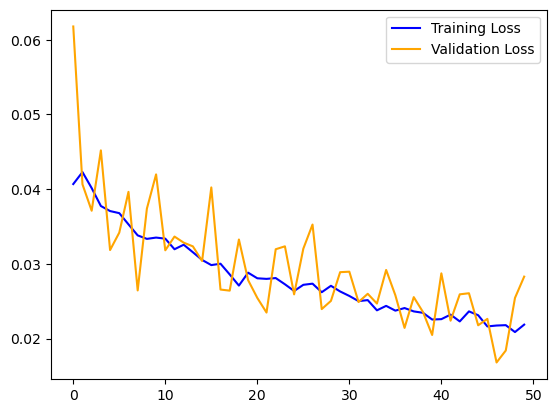

In [160]:
train(attention_model, EPOCHS, X_train, y_train, loss_f=mae_loss, optimizer=adam) # train for another 50 epochs

(0.0021080459, 0.00060834666)

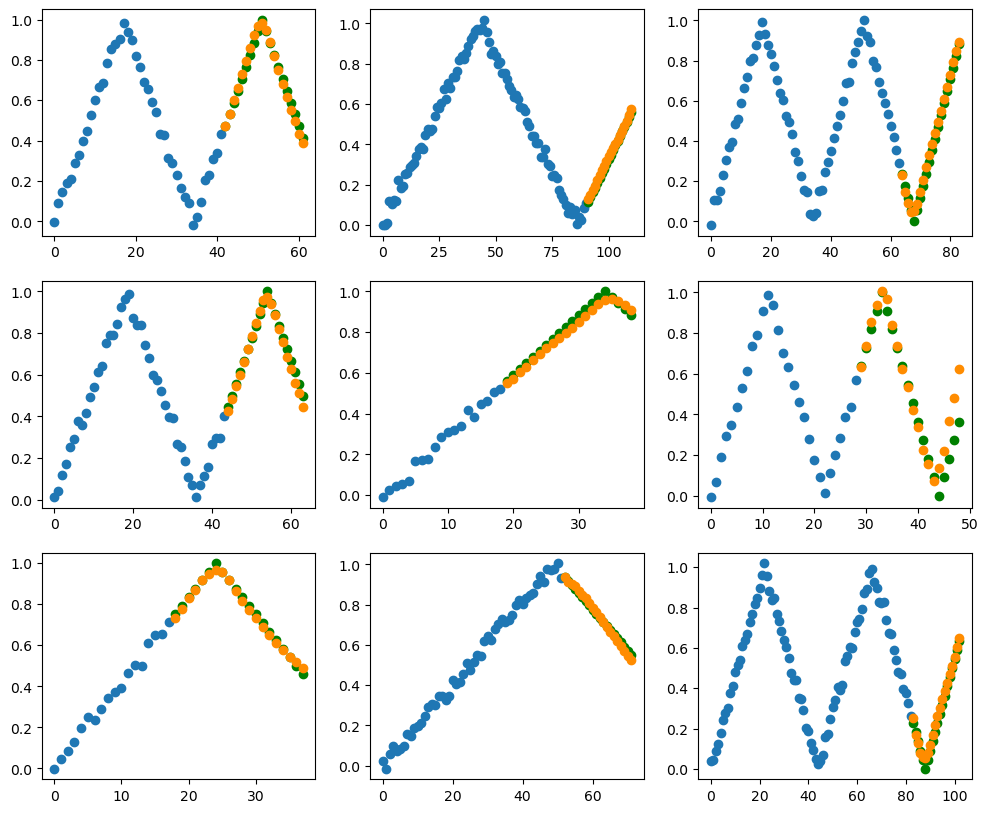

In [165]:
evaluate(attention_model, X_test, y_test, loss_fn=nn.MSELoss())

In [164]:
# torch.save(attention_model, "attention-100.pt")